# Clustering football events based on their event_type

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import nltk

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# --- Step 1: Load the dataset ---
print("Step 1: Loading the dataset...")
file_path = '../data/events.csv'
events = pd.read_csv(file_path)

Step 1: Loading the dataset...


In [4]:
# Check the initial dataset
print(f"Dataset loaded with shape: {events.shape}")
print("Here are the first few rows of the dataset:")
print(events.head())

Dataset loaded with shape: (941009, 22)
Here are the first few rows of the dataset:
     id_odsp   id_event  sort_order  time  \
0  UFot0hit/  UFot0hit1           1     2   
1  UFot0hit/  UFot0hit2           2     4   
2  UFot0hit/  UFot0hit3           3     4   
3  UFot0hit/  UFot0hit4           4     7   
4  UFot0hit/  UFot0hit5           5     7   

                                                text  event_type  event_type2  \
0  Attempt missed. Mladen Petric (Hamburg) left f...           1         12.0   
1  Corner,  Borussia Dortmund. Conceded by Dennis...           2          NaN   
2  Corner,  Borussia Dortmund. Conceded by Heiko ...           2          NaN   
3           Foul by Sven Bender (Borussia Dortmund).           3          NaN   
4  Gokhan Tore (Hamburg) wins a free kick in the ...           8          NaN   

   side         event_team           opponent  ... player_in player_out  \
0     2         Hamburg SV  Borussia Dortmund  ...       NaN        NaN   
1     1 

In [5]:
# I want to figure out how many entries for each event_type we have
print("Number of entries for each event_type:")
print(events['event_type'].value_counts())

Number of entries for each event_type:
event_type
8     237932
3     232925
1     229135
2      91204
7      51738
9      43476
4      39911
10     10730
11      2706
6       1152
5        100
Name: count, dtype: int64


In [6]:
# --- Step 2: Balance the dataset ---
print("\nStep 2: Balancing the dataset...")


Step 2: Balancing the dataset...


In [7]:
# Determine the minimum number of samples for each event_type
min_count = events['event_type'].value_counts().min()
print(f"Minimum samples per event_type: {min_count}")

Minimum samples per event_type: 100


In [8]:
# Take a balanced sample from each event_type
balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


C:\Users\stoic\AppData\Local\Temp\ipykernel_4616\4114648847.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [9]:
# Show the balanced dataset
print(f"Balanced dataset size: {balanced_events.shape}")
print("Balanced event_type distribution:")
print(balanced_events['event_type'].value_counts())

Balanced dataset size: (1100, 22)
Balanced event_type distribution:
event_type
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
Name: count, dtype: int64


In [10]:
balanced_events

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,0G8GNYoU/,0G8GNYoU67,67,68,"Goal! Nice 3, Valenciennes 0. Christian BrA¼l...",1,NaN,1,Nice,Valenciennes,...,NaN,NaN,4.0,1.0,1,13.0,3.0,0,1.0,0
1,2ZNAciJS/,2ZNAciJS11,11,14,Attempt missed. Pierre-Emerick Aubameyang (Bor...,1,12.0,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,6.0,2.0,0,15.0,1.0,1,1.0,0
2,MHXMFuYj/,MHXMFuYj5,5,9,Attempt blocked. Odion Ighalo (Watford) right ...,1,12.0,1,Watford,Manchester City,...,NaN,NaN,2.0,3.0,0,11.0,1.0,1,1.0,0
3,phvfdYJC/,phvfdYJC99,99,84,Attempt missed. Emanuel Herrera (Montpellier) ...,1,12.0,2,Montpellier,Bordeaux,...,NaN,NaN,8.0,2.0,0,15.0,2.0,1,1.0,0
4,4CVSeAbj/,4CVSeAbj65,65,61,Attempt saved. Miguel Angel de las Cuevas (Osa...,1,12.0,1,Osasuna,Rayo Vallecano,...,NaN,NaN,3.0,1.0,0,8.0,1.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,I9ipkH5d/,I9ipkH5d94,94,85,Penalty conceded by Gueida Fofana (Lyon) after...,11,NaN,1,Lyon,AS Nancy Lorraine,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
1096,AgaNr7rG/,AgaNr7rG112,112,85,Penalty Real Zaragoza. Angel Lafita draws a fo...,11,NaN,1,Real Zaragoza,Espanyol,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
1097,GpIke7TP/,GpIke7TP49,49,56,Penalty conceded by Jordi Amat (Swansea City) ...,11,NaN,2,Swansea,Leicester City,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
1098,UcTsbWmt/,UcTsbWmt33,33,35,Penalty Lorient. Benjamin Jeannot draws a foul...,11,NaN,1,Lorient,Marseille,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0


In [11]:
# --- Step 3: Preprocess the text column ---
print("\nStep 3: Preprocessing the text column...")


Step 3: Preprocessing the text column...


In [12]:
# Define text preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in punctuation and not char.isdigit()])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [14]:
# Apply text preprocessing
balanced_events['processed_text'] = balanced_events['text'].apply(preprocess_text)

In [15]:
# Show some examples of preprocessed text
print("Examples of preprocessed text:")
print(balanced_events[['text', 'processed_text']].head())

Examples of preprocessed text:
                                                text  \
0  Goal!  Nice 3, Valenciennes 0. Christian BrA¼l...   
1  Attempt missed. Pierre-Emerick Aubameyang (Bor...   
2  Attempt blocked. Odion Ighalo (Watford) right ...   
3  Attempt missed. Emanuel Herrera (Montpellier) ...   
4  Attempt saved. Miguel Angel de las Cuevas (Osa...   

                                      processed_text  
0  goal nice valenciennes christian bra¼ls nice h...  
1  attempt missed pierreemerick aubameyang boruss...  
2  attempt blocked odion ighalo watford right foo...  
3  attempt missed emanuel herrera montpellier lef...  
4  attempt saved miguel angel de la cuevas osasun...  


In [16]:
# --- Step 4: Convert text to numerical representation using TF-IDF ---
print("\nStep 4: Converting text to numerical representation using TF-IDF...")


Step 4: Converting text to numerical representation using TF-IDF...


In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
text_features = tfidf_vectorizer.fit_transform(balanced_events['processed_text'])

In [18]:
# Convert TF-IDF matrix to DataFrame for better handling
text_features_df = pd.DataFrame(text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [19]:
# Print the shape of the TF-IDF matrix and some feature names
print(f"TF-IDF matrix shape: {text_features_df.shape}")
print("Top 10 TF-IDF features:")
print(text_features_df.columns[:10])

TF-IDF matrix shape: (1100, 1000)
Top 10 TF-IDF features:
Index(['aaron', 'abdullah', 'abel', 'adam', 'adil', 'adrian', 'adrien',
       'aduriz', 'aigner', 'ajaccio'],
      dtype='object')


In [20]:
# --- Step 5: Apply OPTICS clustering ---
print("\nStep 5: Applying OPTICS clustering...")


Step 5: Applying OPTICS clustering...


In [21]:
# Configure and fit OPTICS
optics = OPTICS(min_samples=10, metric='cosine')  # Adjust min_samples as needed
optics.fit(text_features)

OPTICS(metric='cosine', min_samples=10)

In [22]:
# Assign cluster labels
balanced_events['cluster'] = optics.labels_


In [23]:
# Print cluster information
print(f"Number of clusters found (including noise): {balanced_events['cluster'].nunique()}")
print("Cluster distribution:")
print(balanced_events['cluster'].value_counts())

Number of clusters found (including noise): 5
Cluster distribution:
cluster
-1    1046
 2      20
 1      12
 0      12
 3      10
Name: count, dtype: int64


In [24]:
# --- Step 6: Evaluate the clustering ---
print("\nStep 6: Evaluating the clustering...")


Step 6: Evaluating the clustering...


In [25]:
# Exclude noise points (-1)
valid_indices = balanced_events['cluster'] != -1
valid_clusters = balanced_events[valid_indices]

In [26]:
# Convert sparse matrix to dense format for Davies-Bouldin Score
dense_text_features = text_features.toarray()

In [27]:
# Metrics
if valid_clusters['cluster'].nunique() > 1:
    silhouette = silhouette_score(dense_text_features[valid_indices], valid_clusters['cluster'])
    ari = adjusted_rand_score(valid_clusters['event_type'], valid_clusters['cluster'])
    homogeneity = homogeneity_score(valid_clusters['event_type'], valid_clusters['cluster'])
    dbi = davies_bouldin_score(dense_text_features[valid_indices], valid_clusters['cluster'])
else:
    silhouette = ari = homogeneity = dbi = "Not Applicable"

print("\nClustering Results:")
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Homogeneity Score: {homogeneity}")
print(f"Davies-Bouldin Index: {dbi}")


Clustering Results:
Silhouette Score: 0.2930863402231082
Adjusted Rand Index (ARI): 0.8686904702603644
Homogeneity Score: 0.787458907770409
Davies-Bouldin Index: 1.4655097982095726


In [28]:
# --- Step 7: Visualize clusters ---
print("\nStep 7: Visualizing clusters...")


Step 7: Visualizing clusters...


In [29]:
# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(text_features.toarray())

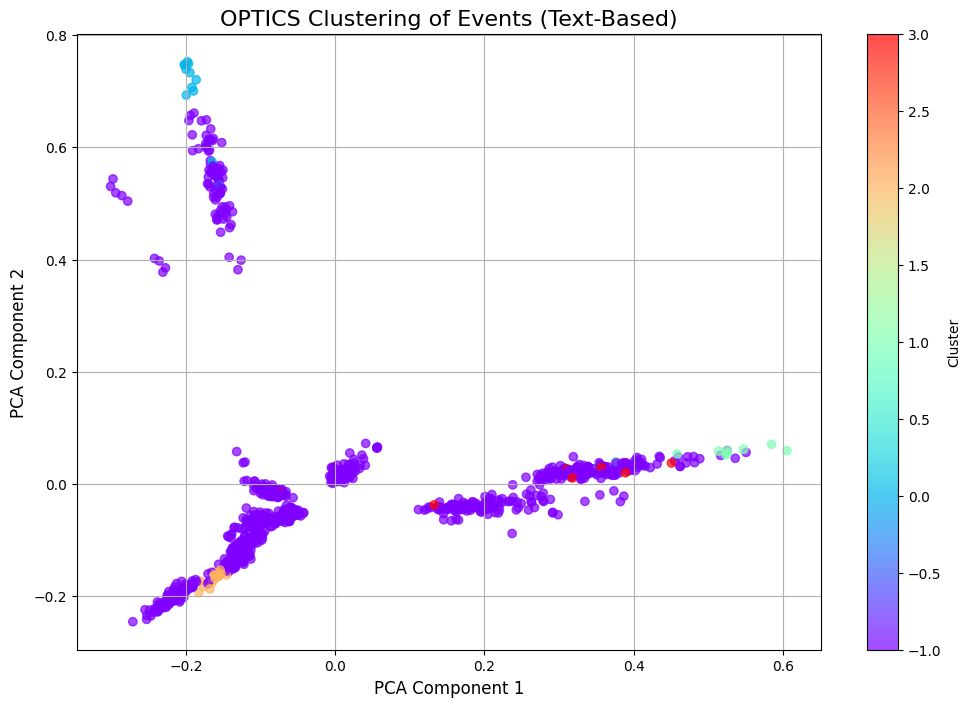

In [30]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    pca_features[:, 0], pca_features[:, 1],
    c=balanced_events['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title("OPTICS Clustering of Events (Text-Based)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.show()

In [31]:
# --- Step 8: Analyze cluster composition ---
print("\nStep 8: Analyzing cluster composition...")


Step 8: Analyzing cluster composition...


In [32]:
# Cluster composition by event type
cluster_composition = balanced_events.groupby('cluster')['event_type'].value_counts(normalize=True)
print("Cluster Composition by Event Type:")
print(cluster_composition)

Cluster Composition by Event Type:
cluster  event_type
-1       1             0.095602
         7             0.095602
         9             0.095602
         2             0.094646
         4             0.094646
         10            0.094646
         3             0.093690
         6             0.091778
         11            0.084130
         5             0.083174
         8             0.076482
 0       11            1.000000
 1       5             0.916667
         4             0.083333
 2       8             1.000000
 3       6             0.400000
         3             0.200000
         5             0.200000
         2             0.100000
         10            0.100000
Name: proportion, dtype: float64


In [33]:
# Visualize cluster compositions
for cluster, composition in cluster_composition.groupby(level=0):
    print(f"\nCluster {cluster}:")
    print(composition)


Cluster -1:
cluster  event_type
-1       1             0.095602
         7             0.095602
         9             0.095602
         2             0.094646
         4             0.094646
         10            0.094646
         3             0.093690
         6             0.091778
         11            0.084130
         5             0.083174
         8             0.076482
Name: proportion, dtype: float64

Cluster 0:
cluster  event_type
0        11            1.0
Name: proportion, dtype: float64

Cluster 1:
cluster  event_type
1        5             0.916667
         4             0.083333
Name: proportion, dtype: float64

Cluster 2:
cluster  event_type
2        8             1.0
Name: proportion, dtype: float64

Cluster 3:
cluster  event_type
3        6             0.4
         3             0.2
         5             0.2
         2             0.1
         10            0.1
Name: proportion, dtype: float64


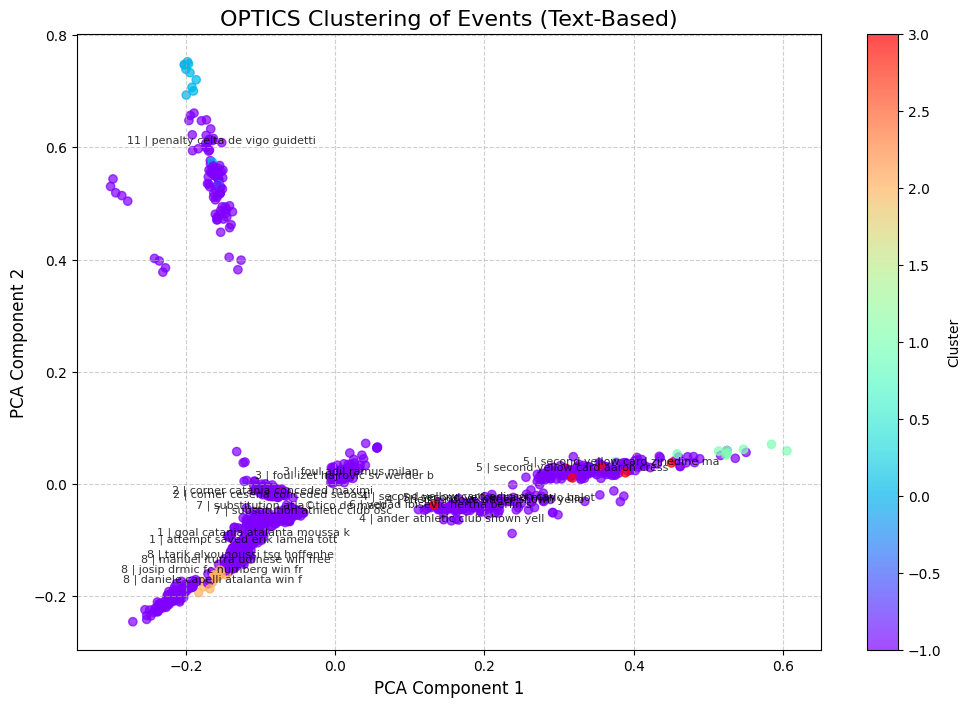

In [34]:
# Annotated Scatter Plot
plt.figure(figsize=(12, 8))

# Scatter plot of clusters
scatter = plt.scatter(
    pca_features[:, 0], 
    pca_features[:, 1],
    c=balanced_events['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title("OPTICS Clustering of Events (Text-Based)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

# Annotate a random sample of events
sample_size = 20  # Adjust to control the number of annotations
sample_indices = balanced_events.sample(n=sample_size, random_state=42).index

for i in sample_indices:
    event_type = balanced_events.loc[i, 'event_type']
    text_snippet = balanced_events.loc[i, 'processed_text'][:30]  # Limit to 30 characters
    plt.text(
        pca_features[i, 0], 
        pca_features[i, 1], 
        f"{event_type} | {text_snippet}", 
        fontsize=8, 
        alpha=0.8,
        ha='center'  # Align text center
    )

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
